In [1]:
!pip install --upgrade seaborn

  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.1
    Uninstalling seaborn-0.11.1:
      Successfully uninstalled seaborn-0.11.1


In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta

from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
import lightgbm
from sklearn.datasets import make_regression
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Для начала загрузим самый важный датасет: результаты измереня температуры

### Структура проекта


[1. Предобработка и анализ данных](#1)

[2.Обучение моделей](#2)

[Вывод](#3)

## 1. Предобработка и анализ данных <a name="1"></a>

__Анализ и предобработка датасета с результатами измерения температуры__

In [3]:
data_arc = pd.read_csv('data_arc.csv')
data_bulk = pd.read_csv('data_bulk.csv')
data_bulk_time = pd.read_csv('data_bulk_time.csv')
data_gas = pd.read_csv('data_gas.csv')
data_temp = pd.read_csv('data_temp.csv')
data_wire = pd.read_csv('data_wire.csv')
data_wire_time = pd.read_csv('data_wire_time.csv')

In [4]:
#data_temp = pd.read_csv('data_temp.csv')
display(data_temp)
data_temp.info()


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


Из данного датасета и других мы узнаем, что у нас есть результаты по 3241 плавке, с которыми нам нужно работать. В качестве целевой метрики используется конечная температура при замере в одной выплавки, следовательно если данного параметра нет - не стоит использовать данные по этим выплавкам, как из этого фотосета, так и по другим.

Посмотрим, сколько уникальных значений выплавок содержится в данном датасете:

In [5]:
print('Количество уникальных видов плавок:', len(data_temp['key'].value_counts()))

Количество уникальных видов плавок: 3216


Как мы видим, нет данных измерения температуры минимум по 25 выплавкам. Посмотрим, у каких номеров выплавок отсутствует конечная температура измерения

In [6]:
data_temp = data_temp.fillna(0)
data_temp['last'] = data_temp.groupby('key')['Температура'].transform('last')
data_temp['first'] = data_temp.groupby('key')['Температура'].transform('first')
data_temp['max'] = data_temp.groupby('key')['Температура'].transform(max)
data_minus = data_temp['key'][data_temp['last'] == 0].unique().tolist()
print('Общее количество выплавок с отсутствующей конечной температурой:',len(data_minus))

Общее количество выплавок с отсутствующей конечной температурой: 739


Цифра получилась приличная, но ничего не поделаешь, придется удалить строки с информацией по данным выплавкам, поскольку целевой признак у них отсутствует. Также добавим максимальную температуру по группе. Это важная инфомация, потому что потенциальный расход электроэнергии, газа и перегрев металла тесно связаны.

In [7]:
data_temp = data_temp.set_index('key')
data_temp = data_temp.drop(index=data_minus)

Проверим данные на выбросы, поскольку температура плавления стали не может быть ниже 1420, то данной температуры быть не может при измерениях. Ни при первичном измерении, ни при крайнем. Также температура в электродуговых при плавке стали никогда не становится выше 1700 градусов. Значения выше или ниже будут означать о некорректности работы печи.


In [8]:
print(data_temp.query('first < 1420 or last > 1700'))

             Время замера  Температура    last   first     max
key                                                           
867   2019-06-04 14:21:00       1191.0  1599.0  1191.0  1600.0
867   2019-06-04 14:29:35       1575.0  1599.0  1191.0  1600.0
867   2019-06-04 14:30:29       1576.0  1599.0  1191.0  1600.0
867   2019-06-04 14:43:10       1571.0  1599.0  1191.0  1600.0
867   2019-06-04 14:52:54       1600.0  1599.0  1191.0  1600.0
867   2019-06-04 14:57:17       1599.0  1599.0  1191.0  1600.0
1214  2019-06-16 05:32:00       1208.0  1591.0  1208.0  1608.0
1214  2019-06-16 05:49:01       1608.0  1591.0  1208.0  1608.0
1214  2019-06-16 05:51:28       1608.0  1591.0  1208.0  1608.0
1214  2019-06-16 05:51:38       1608.0  1591.0  1208.0  1608.0
1214  2019-06-16 05:52:41       1608.0  1591.0  1208.0  1608.0
1214  2019-06-16 05:53:03       1608.0  1591.0  1208.0  1608.0
1214  2019-06-16 05:53:13       1608.0  1591.0  1208.0  1608.0
1214  2019-06-16 05:54:48       1604.0  1591.0  1208.0 

Основные промахи связаны c начальной температурой. Поскольку температура плавления стали существенно выше, скорее всего были допущены промахи с измерением. Нам придется удалить и эти номера выплавок, к счастью, их количество несущественно.

In [9]:
data_temp = data_temp.drop(index=data_temp.query('first < 1420 or last > 1700').index)

Добавим в столбец суммарное время выплавки. Для этого переведем во временной тип столбец "Время замера" и вычтем из конечного времени начальное.

In [10]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'], format='%Y-%m-%d %H:%M:%S')

def seconds(delta):
    return delta.seconds

data_temp['Время нагрева'] = data_temp.groupby('key')['Время замера'].transform('last') - data_temp.groupby('key')['Время замера'].transform('first') 
data_temp['Время нагрева'] = data_temp['Время нагрева'].apply(seconds)

data_temp

,Время замера,Температура,last,first,max,Время нагрева
key,,,,,,
1,2019-05-03 11:16:18,1571.0,1613.0,1571.0,1618.0,861
1,2019-05-03 11:25:53,1604.0,1613.0,1571.0,1618.0,861
1,2019-05-03 11:29:11,1618.0,1613.0,1571.0,1618.0,861
1,2019-05-03 11:30:01,1601.0,1613.0,1571.0,1618.0,861
1,2019-05-03 11:30:39,1613.0,1613.0,1571.0,1618.0,861
...,...,...,...,...,...,...
2498,2019-08-06 02:19:26,1593.0,1594.0,1591.0,1594.0,1302
2498,2019-08-06 02:25:31,1594.0,1594.0,1591.0,1594.0,1302
2499,2019-08-06 02:40:25,1569.0,1603.0,1569.0,1604.0,1203


Поскольку у нас в каждой строке есть номер выплавки, начальная, конечная температура, максимальная температура и общее время нагрева - мы можем удалить дублирующиеся индексы, они же номера плавок, и при этом важная информация для будущего моделирования сохранится.

In [11]:
duplicates = data_temp.index.duplicated()
keep = duplicates == False
data_temp_final = data_temp.loc[keep,:]

data_temp_final = data_temp_final.drop(['Время замера','Температура'], axis = 1)
data_temp_final.head(5)

,last,first,max,Время нагрева
key,,,,
1,1613.0,1571.0,1618.0,861
2,1602.0,1581.0,1608.0,1305
3,1599.0,1596.0,1599.0,1300
4,1625.0,1601.0,1625.0,388
5,1602.0,1576.0,1602.0,762


Добавим в качестве признака среднее значение всех последних температур. Идеальная температура перед машиной непрерывной разливки стали зависит от так называемой температуры - ликвидус, которая зависит от химического состава расплава. Поскольку данных нет, посчитаем среднее значение последнего замера температуры. Данный признак может помочь нам примерно понять, к какой температуре приблизительно хотят прийти сталевары во время плавки в электро-дуговой печи.

In [12]:
#data_temp_final['avg'] = data_temp_final['last'].mean()

В итоге исследования и предобработки датасета с температурой мы отбросили все плавки без целевого признака, все плавки, где температура нереальна, учитывая процессы, проходящие в электродуговой металлругической печи. Для будущих признаков оставили только начальную и конечную температуру, а также добавили общее время нагрева.

__Анализ и предобработка данных об электродах__

Вторая по значимости таблица данных, которая содержит инофрмацию об энергии, которая была затрачена при выплавке стали.

In [13]:
#data_arc = pd.read_csv('data_arc.csv')
display(data_arc.head(15))
data_arc.info()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


В данной таблице мы видим информацию о периодах подключения электрической дуги для нагрева стали, а также затраченной мощности (активной и реактивной). Попробуем свести данный датасет к одному параметру - работе (А). Посчитаем полную мощность, рассчитаем время нагрева и вычислим суммарную работу по каждой плавке.

In [14]:
data_arc['Полная мощность'] = (data_arc['Активная мощность']**2 + data_arc['Реактивная мощность']**2)**0.5

In [15]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')

data_arc['Продолжительность нагрева'] = data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']

data_arc['Продолжительность нагрева'] = data_arc['Продолжительность нагрева'].apply(seconds)

In [16]:
data_arc['Работа'] = data_arc['Продолжительность нагрева'] * data_arc['Полная мощность']

In [17]:
data_arc_final = data_arc.pivot_table(index = ['key'], values = 'Полная мощность', aggfunc = 'sum')
data_arc_final.head(5)

,Полная мощность
key,
1,5.826395
2,3.649216
3,2.989534
4,3.814962
5,4.035758


В результате исследования и преобработки данных по электродам мы получили информацию о суммарной работе, затраченную на каждую выплавку. 

__Анализ и предобработка данных о продувке сплава газом__

Продувка стали инернтыми газами служит для:
 * уменьшение содержания газов в металле
 * интенсивное перемешивание расплава
 * улучшение условий протекания реакции окисления углерода;
 * снижение температуры металла.

Поскольку продувка напрямую связана с температурой стали, объем использованного газа - важный параметр для построения модели.

In [18]:
#data_gas = pd.read_csv('data_gas.csv')
display(data_gas)
data_gas.info()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Данные не содержат пропусков, все типы верные. Посмотрим на гистограмму распределения данных по газу.

Text(0.5, 1.0, 'Объем газа')

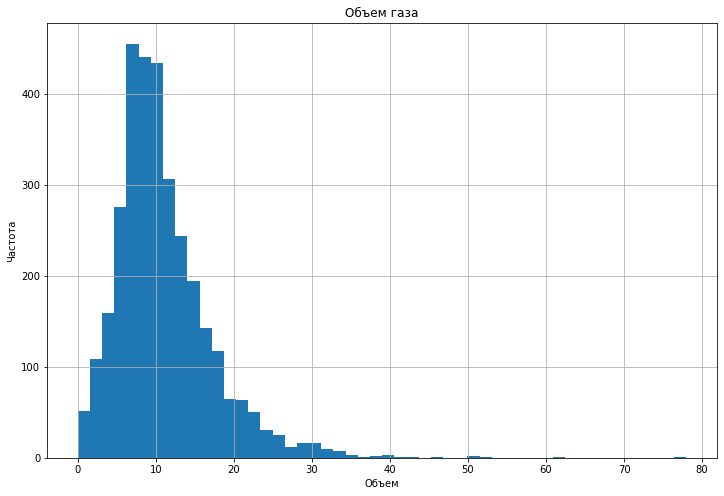

In [19]:
data_gas['Газ 1'].hist(bins = 50, figsize=(12,8))
plt.xlabel('Объем')
plt.ylabel('Частота')
plt.title('Объем газа')

Выбросов при гистаграмме не наблюдается, поэтому можно смело переводить номер варки в индекс и в дальнейшем использовать объем газа как признак.

In [20]:
data_gas = data_gas.set_index('key')

__Анализ и предобработка датасета с данными о подаче сыпучих материалов__

Сыпучие материалы используют для выведения вредных примесей и корректировки содержания процента углерода в стали.

In [21]:
#data_bulk = pd.read_csv('data_bulk.csv')
display(data_bulk)
data_bulk.info()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Данные содержат множество пропусков. Пропуски говорят о том, что присадки не было нужды добавлять при выплавке стали и корректировать состав. Заменим пропуски на 0 и проанализируем, какие присадки использовались чаще всех.

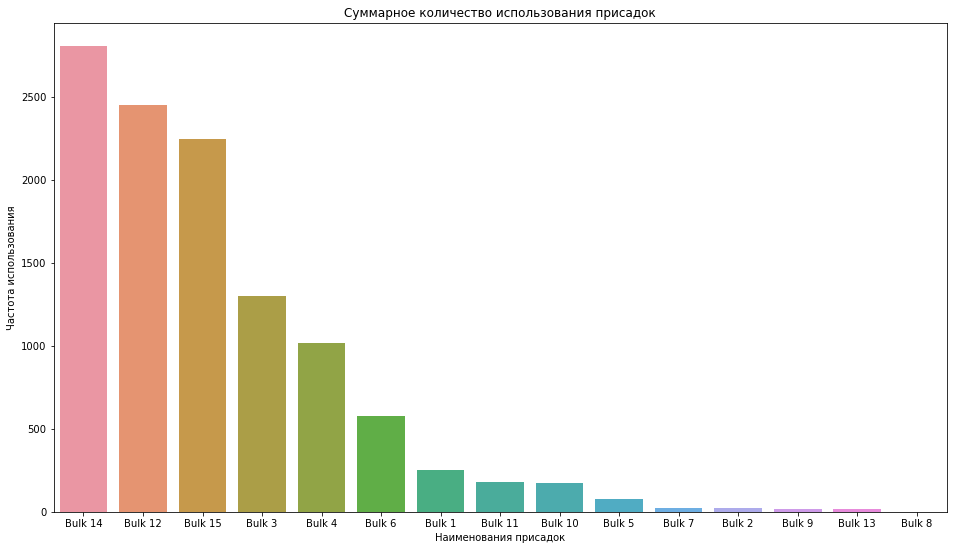

In [22]:
data_bulk = data_bulk.fillna(0)
data_bulk = data_bulk.set_index('key')
bulk_stat = pd.DataFrame(data_bulk[data_bulk>0].count().sort_values(ascending = False))


plt.figure(figsize=(16,9)) 
gr = sns.barplot(x=bulk_stat.index, y=bulk_stat[0]).set_title('Суммарное количество использования присадок')
plt.xlabel('Наименования присадок')
plt.ylabel('Частота использования')
plt.show()



Как видно из графика, наиболее часто используются присадки 14,12,15. Больше тысячи раз используются 3 4. Чтобы не перегружать признаки, добавим топ 7 самых популярных присадок в претенденты на признаки.

In [23]:
top_bulki = data_bulk[data_bulk>0].count().sort_values(ascending = False).iloc[0:8].index.unique().tolist()

In [24]:
data_bulk_final = data_bulk[top_bulki].set_index(data_bulk.index)
data_bulk_final.head(5)

,Bulk 14,Bulk 12,Bulk 15,Bulk 3,Bulk 4,Bulk 6,Bulk 1,Bulk 11
key,,,,,,,,
1,150.0,206.0,154.0,0.0,43.0,0.0,0.0,0.0
2,149.0,206.0,154.0,0.0,73.0,0.0,0.0,0.0
3,152.0,205.0,153.0,0.0,34.0,0.0,0.0,0.0
4,153.0,207.0,154.0,0.0,81.0,0.0,0.0,0.0
5,151.0,203.0,152.0,0.0,78.0,0.0,0.0,0.0


__Анализ и предобработка датасета с данными о подаче проволочных материалов__

In [25]:
#data_wire = pd.read_csv('data_wire.csv')
display(data_wire)
data_wire.info()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


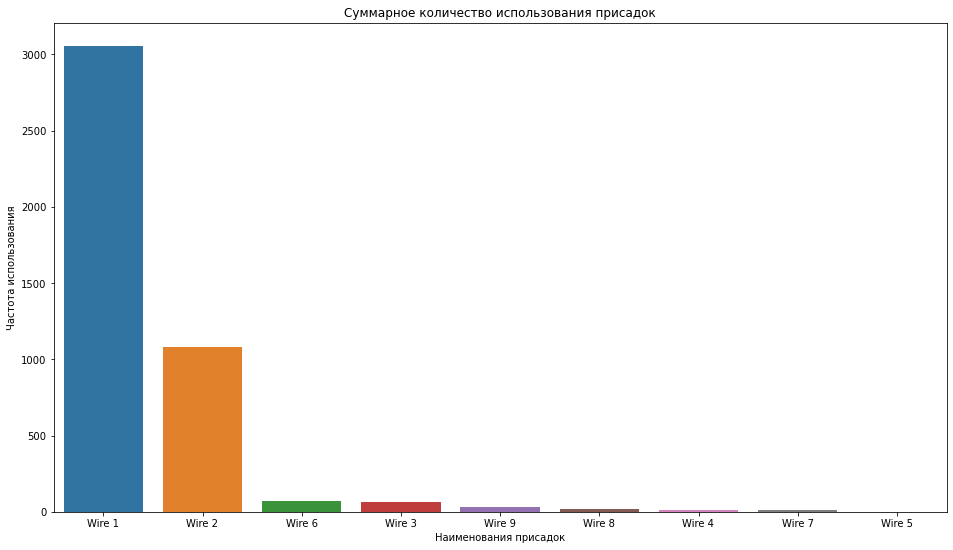

In [26]:
data_wire = data_wire.fillna(0)
data_wire = data_wire.set_index('key')
wire_stat = pd.DataFrame(data_wire[data_wire>0].count().sort_values(ascending = False))


plt.figure(figsize=(16,9)) 
gr = sns.barplot(x=wire_stat.index, y=wire_stat[0]).set_title('Суммарное количество использования присадок')
plt.xlabel('Наименования присадок')
plt.ylabel('Частота использования')
plt.show()

In [27]:
top_wire = data_wire[data_wire>0].count().sort_values(ascending = False).iloc[0:2].index.unique().tolist()

In [28]:
data_wire_final = data_wire[top_wire].set_index(data_wire.index)
data_wire_final.head(5)

,Wire 1,Wire 2
key,,
1,60.059998,0.00000
2,96.052315,0.00000
3,91.160157,0.00000
4,89.063515,0.00000
5,89.238236,9.11456


Судя по графику использования проволочных материалов, проволочные материалы под кодовыми названиями `Wire 1` и `Wire 2`. Использовались чаще других. Возьмем их в нашу таблицу признаков. Остальные оставим истории.

__Анализ и предобработка датасета с данными о подаче сыпучих материалов (время) и с данными о проволочных материалах (время)__

Посмотрим на информацию в датасетах, содеражащую информацию о времени добавления сыпучих и проволочных матрериалов.

In [29]:
#data_wire_time = pd.read_csv('data_wire_time.csv')
display(data_wire_time)
data_wire_time.info()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [30]:
#data_bulk_time = pd.read_csv('data_wire_time.csv')
display(data_wire_time)
data_wire_time.info()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Данные содержат информацию о том в какое время были исользованы те или иные сыпучие или проволочные материалы. Данные важны скорее для производства, но использование их при создании моделей нерпрезентативно. Оставим только данные о количестве, полученные выше

__План дальнейшей работы__

1. Соединить все таблицы в одну. Для финальной таблицы признаков оставим следующие таблицы: 
 * data_wire_final
 * data_bulk_final
 * data_gas
 * data_arc_final
 * data_temp_final
 

2. Поскольку все признаки носят количественный характер - проведем масштабирование признаков методом StandardScaler().  

3. Разделим данные на тренировочную и тестовыую выборку. Чтобы построить модель лучшего качества - воспользуемся механизмом кросс-валидации для лучшего подбора гиперпараметров.

4. Создадим модели Линейной регрессии, Случайного леса, Решающего дерева, модели градиентного бустинга CatBoost и LGBMRegressor. Посмотрим на лучший результат при кросс-валидации.


5. Обучим модели на тестовой выборке и сравним лучшие результаты.

## 2. Обучение моделей <a name="2"></a>

Соединим таблицы в одну

In [31]:
final_data = data_temp_final.join(data_arc_final)
final_data = final_data.join(data_gas)
final_data = final_data.join(data_bulk_final)
final_data = final_data.join(data_wire_final)

Проверим взаимосвязть признаков с целевым параметром и корреляцию признаков между собой

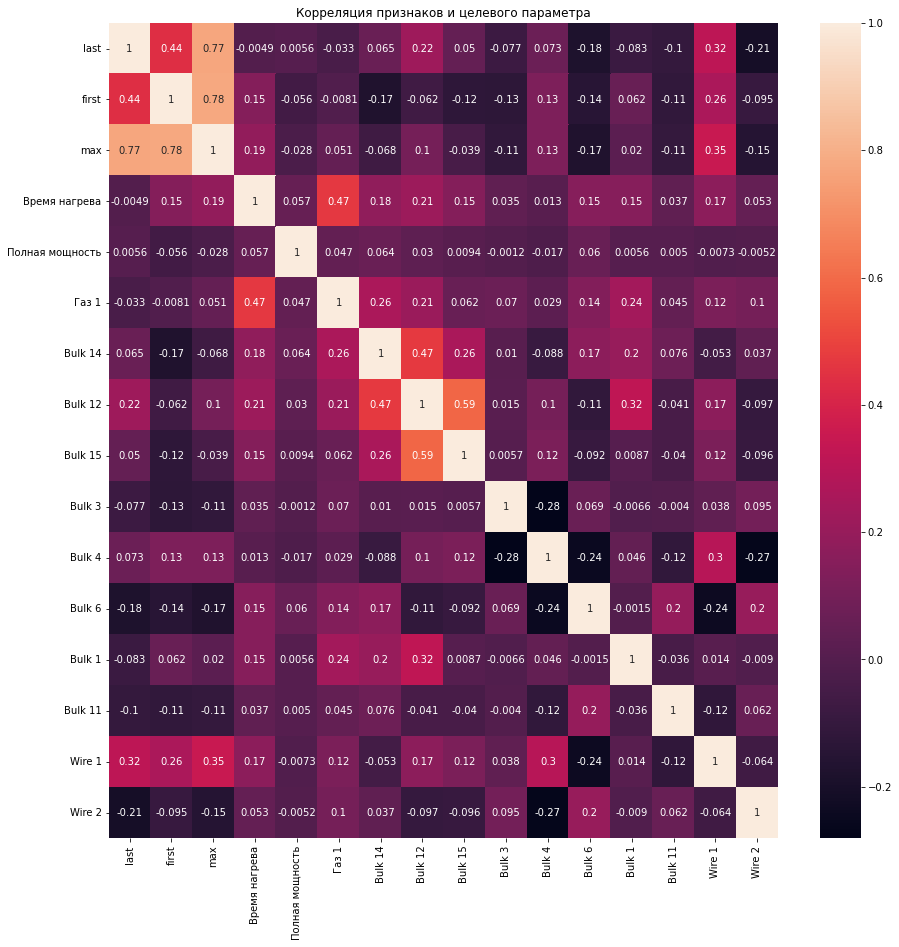

In [32]:
def heatmap(data, title):
    cols = final_data.columns
    plt.figure(figsize=(15, 15))
    hm = sns.heatmap(data[cols].corr(), cbar=True, annot=True)
    plt.title(title)
    plt.show();
    
heatmap(final_data, 'Корреляция признаков и целевого параметра') 

In [33]:
#cоздадим копию датасета для catboost
final_data_catboost = final_data.copy()

#удалим стркоки с пропусками
final_data = final_data.dropna()

In [34]:
final_data

,last,first,max,Время нагрева,Полная мощность,Газ 1,Bulk 14,Bulk 12,Bulk 15,Bulk 3,Bulk 4,Bulk 6,Bulk 1,Bulk 11,Wire 1,Wire 2
key,,,,,,,,,,,,,,,,
1,1613.0,1571.0,1618.0,861,5.826395,29.749986,150.0,206.0,154.0,0.0,43.0,0.0,0.0,0.0,60.059998,0.00000
2,1602.0,1581.0,1608.0,1305,3.649216,12.555561,149.0,206.0,154.0,0.0,73.0,0.0,0.0,0.0,96.052315,0.00000
3,1599.0,1596.0,1599.0,1300,2.989534,28.554793,152.0,205.0,153.0,0.0,34.0,0.0,0.0,0.0,91.160157,0.00000
4,1625.0,1601.0,1625.0,388,3.814962,18.841219,153.0,207.0,154.0,0.0,81.0,0.0,0.0,0.0,89.063515,0.00000
5,1602.0,1576.0,1602.0,762,4.035758,5.413692,151.0,203.0,152.0,0.0,78.0,0.0,0.0,0.0,89.238236,9.11456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1591.0,1570.0,1591.0,1137,3.986869,7.125735,129.0,256.0,223.0,21.0,0.0,0.0,0.0,0.0,89.150879,0.00000
2496,1591.0,1554.0,1595.0,1618,5.057033,9.412616,129.0,256.0,226.0,0.0,63.0,0.0,0.0,0.0,114.179527,0.00000
2497,1589.0,1571.0,1589.0,717,2.885017,6.271699,124.0,230.0,226.0,0.0,85.0,0.0,0.0,0.0,94.086723,9.04800


__Подготовка данных для моделей__

In [35]:
target=final_data['last']
features=final_data.drop('last', axis=1)

numerical = features.columns

scaler = StandardScaler()
scaler.fit(final_data[numerical])
features[numerical] = scaler.transform(final_data[numerical])

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.75, random_state = 90, shuffle = True)

__Подготовка данных для Catboost__

In [36]:
target_cat=final_data_catboost['last']
features_cat=final_data_catboost.drop('last', axis=1)

numerical_cat = features_cat.columns

scaler = StandardScaler()
scaler.fit(final_data_catboost[numerical_cat])
features_cat[numerical_cat] = scaler.transform(final_data_catboost[numerical])

features_train_cat, features_test_cat, target_train_cat, target_test_cat = train_test_split(
    features_cat, target_cat, test_size=0.75, random_state = 90, shuffle = True)

__Модель линейной регрессии__

In [37]:
linear_model = LinearRegression(normalize=True)

n_jobs = np.logspace(-100, 100, 10)
param_grid = {'n_jobs':  n_jobs}

linear_model_cv = GridSearchCV(linear_model, param_grid, cv = 3)
linear_model_cv.fit(features_train,target_train)
linear_model_cv.best_params_

{'n_jobs': 1e-100}

In [38]:
%%time

linear_model = LinearRegression(normalize=True, n_jobs = 1e-100)
linear_model.fit(features_train,target_train)
result = cross_val_score(linear_model,features_train,target_train, cv=3, scoring="neg_mean_absolute_error")
print('Метрика MAE для линейной регрессии:', result.max()*(-1))

Метрика MAE для линейной регрессии: 4.8475487871988125
Wall time: 26 ms


__Модель решающего дерева__

In [39]:
cv = KFold(n_splits=3, shuffle=True, random_state=90)

DecisionTreemodel=DecisionTreeRegressor(random_state=90)

DecisionTreemodel.fit(features_train,target_train)
result = cross_val_score(DecisionTreemodel,features_train,target_train, cv=3, scoring="neg_mean_absolute_error")
print('Метрика MAE для линейной регрессии:', result.max()*(-1))

Метрика MAE для линейной регрессии: 5.324742268041237


__Модель случайного леса__

In [40]:
RandomForestmodel=RandomForestRegressor(random_state=90)

params = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'n_estimators': [10, 20, 30 ,40, 50, 60, 70, 80],
     }

grid_RandomForestmodel = GridSearchCV(RandomForestmodel, params, cv=cv, scoring='neg_mean_squared_error', verbose=False)

grid_RandomForestmodel.fit(features_train, target_train)
grid_RandomForestmodel.best_params_

{'max_depth': 10, 'n_estimators': 80}

In [41]:
RandomForestmodel=RandomForestRegressor(random_state=90, n_estimators = 80, max_depth=10)
RandomForestmodel.fit(features_train,target_train)
result = cross_val_score(RandomForestmodel,features_train,target_train, cv=3, scoring="neg_mean_absolute_error")            
print('Метрика MAE для случайного леса:', result.max()*(-1))

Метрика MAE для случайного леса: 4.212143809202134


__Модель Catboost__

In [42]:
model_catboost = CatBoostRegressor(random_state=90, loss_function='RMSE', silent=True, cat_features=None)

params = {
    'learning_rate': np.logspace(-3, 0, 5),
    'iterations': [60, 80],
    'depth': [6, 8, 10],}

grid_model_catboost = GridSearchCV(model_catboost, params, cv=cv, scoring='neg_mean_squared_error', verbose=False)

grid_model_catboost.fit(features_train_cat, target_train_cat)
grid_model_catboost.best_params_

{'depth': 6, 'iterations': 80, 'learning_rate': 0.1778279410038923}

In [43]:
%%time
model_catboost=CatBoostRegressor(
    random_state=90, loss_function='RMSE', iterations = 80, depth=6, learning_rate=0.1778279410038923)

model_catboost.fit(features_train_cat, target_train_cat, cat_features=None, verbose = False)
result = cross_val_score(model_catboost,features_train_cat, target_train_cat, cv=3, scoring="neg_mean_absolute_error")

print('Метрика MAE для Catboost:', result.max()*(-1))

0:	learn: 13.6671853	total: 2.3ms	remaining: 182ms
1:	learn: 12.5592689	total: 4.1ms	remaining: 160ms
2:	learn: 11.7234878	total: 6.25ms	remaining: 160ms
3:	learn: 10.9658839	total: 7.99ms	remaining: 152ms
4:	learn: 10.3057177	total: 9.86ms	remaining: 148ms
5:	learn: 9.4561528	total: 11.7ms	remaining: 144ms
6:	learn: 8.9489940	total: 13.5ms	remaining: 141ms
7:	learn: 8.4674661	total: 15.8ms	remaining: 143ms
8:	learn: 8.1249295	total: 17.7ms	remaining: 140ms
9:	learn: 7.6927837	total: 19.5ms	remaining: 137ms
10:	learn: 7.4779887	total: 21.8ms	remaining: 137ms
11:	learn: 7.1634470	total: 23.7ms	remaining: 135ms
12:	learn: 6.7771294	total: 25.6ms	remaining: 132ms
13:	learn: 6.4558385	total: 27.6ms	remaining: 130ms
14:	learn: 6.1922420	total: 29.8ms	remaining: 129ms
15:	learn: 6.0104198	total: 31.7ms	remaining: 127ms
16:	learn: 5.7773386	total: 33.6ms	remaining: 124ms
17:	learn: 5.5371673	total: 35.8ms	remaining: 123ms
18:	learn: 5.3035809	total: 37.7ms	remaining: 121ms
19:	learn: 5.131152

__Модель LGBMRegressor__

In [44]:
model_lgb = LGBMRegressor(boosting_type='gbdt', verbose=0, random_state=90)

params = {
    'learning_rate': np.logspace(-3, 0, 5),
    'n_estimators': [40, 60],
    'num_leaves': [21, 31, 41],
    'iterations': [40, 60, 80]
}

grid_model_lgb = GridSearchCV(model_lgb, params, cv=cv, scoring='neg_mean_squared_error', verbose=True)

grid_model_lgb.fit(features_train, target_train)

Fitting 3 folds for each of 90 candidates, totalling 270 fits
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   20.2s finished


GridSearchCV(cv=KFold(n_splits=3, random_state=90, shuffle=True),
             estimator=LGBMRegressor(random_state=90, verbose=0),
             param_grid={'iterations': [40, 60, 80],
                         'learning_rate': array([0.001     , 0.00562341, 0.03162278, 0.17782794, 1.        ]),
                         'n_estimators': [40, 60], 'num_leaves': [21, 31, 41]},
             scoring='neg_mean_squared_error', verbose=True)

In [45]:
%%time

model_lgb = LGBMRegressor(
    n_estimators=40, num_leaves=21, num_iterations=40, learning_rate=0.1778279410038923, random_state=90)

model_lgb.fit(features_train, target_train, verbose=False)
result = cross_val_score(model_lgb,features_train,target_train, cv=3, scoring="neg_mean_absolute_error")

print('Метрика MAE для LGBMRegressor:', result.max()*(-1))

Метрика MAE для LGBMRegressor: 4.3363567185403324
Wall time: 94 ms


__Проверка на тестовой выборке__

In [46]:
def get_me_results(model,features_test, target_test):
    
    predictions = model.predict(features_test)
    result = mean_absolute_error(target_test, predictions)
    
    return result

In [47]:
models = (linear_model, DecisionTreemodel, RandomForestmodel, model_catboost,model_lgb)
models_list = ('Linear_model', 'DecisionTreemodel', 'RandomForestmodel', 'Model_catboost', 'Model_lgb')
results = []

for model in models:
    result = get_me_results(model,features_test, target_test)
    results.append(result)

In [48]:
df = pd.DataFrame(results, index = models_list)
df.columns = ['MAE']
display(df.sort_values(by = 'MAE', ascending = True))

,MAE
Model_catboost,3.759784
RandomForestmodel,3.824475
Model_lgb,3.957483
DecisionTreemodel,5.110665
Linear_model,6.462643


__Оценка важности признаков__

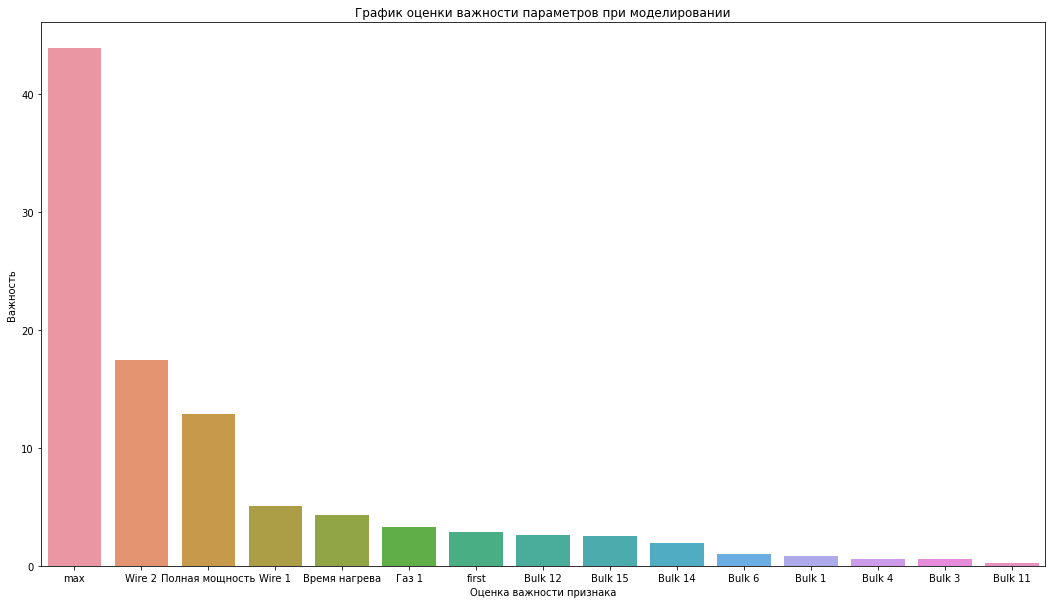

In [49]:
feature_importances = pd.DataFrame(model_catboost.feature_importances_, columns = ['importances'], index = numerical).sort_values(by = 'importances', ascending = False)

plt.figure(figsize=(18,10)) 
fi = sns.barplot(x=feature_importances.index, y=feature_importances['importances']).set_title('График оценки важности параметров при моделировании')
plt.xlabel('Оценка важности признака')
plt.ylabel('Важность')
plt.show()

## Вывод <a name="3"></a>

Исходная задача выполнена - создать модель, при которой значение метрики MAE будет ниже 6. Из пяти тестируемых моделей с этой задаей справились 5. Лучше всего себя показала себя модель Catboost, а самым важным признаком максимальная темпретура металла в ходе плавки.